# All-optical control

Replication of [Rickgauer et al., 2014, Figure 3C](https://www.nature.com/articles/nn.3866/figures/3).
Last run with Cleo version 0.15.0.

## Preamble

In [1]:
import brian2 as b2
from brian2 import np
import cleo
from cleo import opto, imaging, light
import matplotlib.pyplot as plt

# for reproducibility
rng = np.random.default_rng(92)
np.random.seed(92)

cleo.utilities.style_plots_for_paper()

## Brian network setup
All we need are LIF neurons that will spike in response to photostimulation for us to see the resulting fluorescence traces.

In [2]:
ng = b2.NeuronGroup(
    100,
    """dv/dt = (-(v - E_L) + Rm*Iopto) / tau_m : volt
    Iopto : amp""",
    threshold="v > -50*mV",
    reset="v=E_L",
    namespace={
        "tau_m": 20 * b2.ms,
        "Rm": 500 * b2.Mohm,
        "E_L": -70 * b2.mV,
    },
)
ng.v = -70 * b2.mV
cleo.coords.assign_coords_rand_rect_prism(
    ng, [-75, 75], [-75, 75], [50, 150], unit=b2.um
)
sim = cleo.CLSimulator(b2.Network(ng))

## Microscope/GECI configuration

In [3]:
# variable expression
# rho_rel_gen = lambda n: rng.lognormal(0, 0.2, size=n)
# reuse same sample to have same expression for both GECIs
rho_rel = rng.lognormal(0, 0.2, size=100)
rho_rel_gen = lambda n: rho_rel[:n]

scopes = []

for i, geci in enumerate(
    [
        imaging.gcamp6f(doub_exp_conv=False),
        imaging.jgcamp7f(doub_exp_conv=False),
        imaging.ogb_1(doub_exp_conv=False),
    ]
):
    scope = imaging.Scope(
        focus_depth=100 * b2.um,
        img_width=150 * b2.um,
        sensor=geci,
        name=f"scope{i}",
    )
    sim.inject(scope, ng, rho_rel_generator=rho_rel_gen)
    scope.inject_sensor_for_targets()
    scopes.append(scope)
    i_targets = scope.i_targets_for_neuron_group(ng)
    print(scope.n)

WARNING    /home/kyle/Dropbox (GaTech)/projects/cleo/cleo/imaging/scope.py:281: UserWarning: SNR cutoff not used, since OGB-1 does not have dFF_1AP defined.
  warnings.warn(
 [py.warnings]


15
15
15


In [1]:
cleo.viz.plot(ng, colors=["#c500cc"], devices=[scopes[0]])

NameError: name 'cleo' is not defined

## 2p stimulation configuration

In [5]:
opsin = opto.vfchrimson_4s()
opsin.spectrum.append((1060, 0.01))
sim.inject(opsin, ng)

CLSimulator(io_processor=None, devices={GECI(name='OGB-1', save_history=True, model='\n            dCa/dt = -gamma * (Ca - Ca_rest) / (1 + kappa_S + kappa_B) : mmolar (clock-driven)\n            kappa_B = B_T * K_d / (Ca + K_d)**2 : 1\nCaB_active = Ca: mmolar\nexc_factor = 1 : 1\n\n            dFF_baseline = 1 / (1 + (K_d / Ca_rest) ** n_H) : 1\n            dFF = exc_factor * rho_rel * dFF_max  * (\n                1 / (1 + (K_d / CaB_active) ** n_H)\n                - dFF_baseline\n            ) : 1\n            rho_rel : 1\n        ', on_pre='Ca += dCa_T / (1 + kappa_S + kappa_B)', sigma_noise=0.030227272727272728, dFF_1AP=None, location='cytoplasm', cal_model=DynamicCalcium(on_pre='Ca += dCa_T / (1 + kappa_S + kappa_B)', model='\n            dCa/dt = -gamma * (Ca - Ca_rest) / (1 + kappa_S + kappa_B) : mmolar (clock-driven)\n            kappa_B = B_T * K_d / (Ca + K_d)**2 : 1', Ca_rest=50. * nmolar, gamma=292.3 * hertz, B_T=200. * umolar, kappa_S=110, dCa_T=7.6 * umolar), bind_act_mo

In [6]:
laser = light.tp_light_from_scope(scope, wavelength=1060 * b2.nmeter, name="2P light")
sim.inject(laser, ng)

CLSimulator(io_processor=None, devices={GECI(name='OGB-1', save_history=True, model='\n            dCa/dt = -gamma * (Ca - Ca_rest) / (1 + kappa_S + kappa_B) : mmolar (clock-driven)\n            kappa_B = B_T * K_d / (Ca + K_d)**2 : 1\nCaB_active = Ca: mmolar\nexc_factor = 1 : 1\n\n            dFF_baseline = 1 / (1 + (K_d / Ca_rest) ** n_H) : 1\n            dFF = exc_factor * rho_rel * dFF_max  * (\n                1 / (1 + (K_d / CaB_active) ** n_H)\n                - dFF_baseline\n            ) : 1\n            rho_rel : 1\n        ', on_pre='Ca += dCa_T / (1 + kappa_S + kappa_B)', sigma_noise=0.030227272727272728, dFF_1AP=None, location='cytoplasm', cal_model=DynamicCalcium(on_pre='Ca += dCa_T / (1 + kappa_S + kappa_B)', model='\n            dCa/dt = -gamma * (Ca - Ca_rest) / (1 + kappa_S + kappa_B) : mmolar (clock-driven)\n            kappa_B = B_T * K_d / (Ca + K_d)**2 : 1', Ca_rest=50. * nmolar, gamma=292.3 * hertz, B_T=200. * umolar, kappa_S=110, dCa_T=7.6 * umolar), bind_act_mo

## 3D view

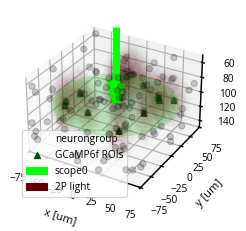

In [7]:
lim = scope.img_width / 2 / b2.um
fig, ax = cleo.viz.plot(
    ng,
    colors=["k"],
    devices=[scopes[0], (laser, {"intensity": 0.12})],
    figsize=(2.5, 2.5),
    scatterargs={"rasterized": True},
    xlim=(-lim, lim),
    ylim=(-lim, lim),
    zlim=(50, 150),
)
fig.savefig("img/fig/all-optical-3d.svg", bbox_inches="tight", transparent=True)

## 2D scope view

In [8]:
import seaborn as sns

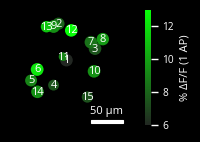

In [9]:
# anchored size bar
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.collections import EllipseCollection

with plt.style.context("dark_background"):
    fig, ax = plt.subplots(figsize=(2.5, 1.5))
    x, y = ng.x[i_targets] / b2.um, ng.y[i_targets] / b2.um
    lim = scope.img_width * 1.2 / b2.um / 2
    ax.set(xlim=(-lim, lim), ylim=(-lim, lim), aspect="equal")

    perp_dist = np.abs(ng.z[i_targets] - scope.focus_depth)
    r_visible = np.sqrt(scope.soma_radius**2 - perp_dist**2)
    r_visible_um = r_visible / b2.um
    cmap = sns.dark_palette("xkcd:fluorescent green", as_cmap=True)
    rois = EllipseCollection(
        r_visible_um * 2,
        r_visible_um * 2,
        0,
        units="xy",
        offsets=np.c_[x, y],
        offset_transform=ax.transData,
        cmap=cmap,
    )
    rois.set_array(100 * scopes[0].dFF_1AP)
    ax.add_collection(rois)
    # easier, more accurate with EllipseCollection
    # r_visible_pt = r_visible / scope.img_width * ax.bbox.width
    # markerarea = np.pi * r_visible_pt**2
    # rois = ax.scatter(x, y, s=markerarea, c=scope.dFF_1AP, cmap=cmap)

    scale_um = 50
    ax.add_artist(
        AnchoredSizeBar(
            ax.transData,
            scale_um,
            f"{scale_um} µm",
            "lower right",
            frameon=False,
            color="w",
            label_top=True,
            size_vertical=scale_um / 10,
        )
    )
    ax.set_axis_off()
    # annotate each neuron with its index
    for i_img, (x_, y_) in enumerate(zip(x, y)):
        ax.annotate(
            i_img + 1,
            (x_, y_),
            # (x_ + 15, y_),
            color="w",
            ha="center",
            va="center",
            annotation_clip=False,
            fontsize=8,
        )

    cbar = fig.colorbar(rois, label="% ΔF/F (1 AP)", drawedges=False, pad=0.1)
    cbar.outline.set_visible(False)
    # cbar.ax.yaxis.set_ticks([])
    plt.rc("svg", fonttype="none")
    fig.savefig("img/fig/all-optical-2d.svg", bbox_inches="tight", transparent=False)

## Stimulating one at a time; on- vs. off-target effects

In [10]:
from cleo.ioproc import LatencyIOProcessor

# for seeing ground-truth spikes
smon = b2.SpikeMonitor(ng, record=i_targets)
sim.network.add(smon)

amplitude_mW = 2.5
pulse_width_ms = 2
interpulse_ms = 10
t_stim_onset_ms = 100
num_pulses = 10
t_stim_end_ms = t_stim_onset_ms + interpulse_ms * num_pulses
t_end_ms = 800


class IOProc(LatencyIOProcessor):
    i: int

    def process(self, state_dict, time_ms):
        t_in_cycle = time_ms % interpulse_ms
        on = (
            (t_in_cycle < pulse_width_ms)
            & (time_ms >= t_stim_onset_ms)
            & (time_ms < t_stim_end_ms)
        )
        power = np.zeros(scope.n)
        power[self.i] = on * amplitude_mW

        return {"2P light": power}, time_ms


sim.set_io_processor(IOProc(1))

dFFs_per_scope = [[] for _ in scopes]
n_targets = scope.n
# n_targets = 5
for i_img in range(n_targets):
    sim.reset()
    sim.io_processor.i = i_img
    sim.run(t_end_ms * b2.ms, report="text", report_period=120 * b2.second)
    for scope, dFFs in zip(scopes, dFFs_per_scope):
        dFFs.append(np.array(scope.dFF)[::20, :])  # downsample from 1000 to 50 Hz
    n_spks_i = smon.count[i_targets[i_img]]

    print(
        f"ROI {i_img+1} spiked {n_spks_i} times. Other ROIs spiked {len(smon.t) - n_spks_i} times"
    )

t_ms = np.array(scope.t_ms)[::20]

WARNING    'rho_rel' is an internal variable of group 'syn_vf_Chrimson_neurongroup', but also exists in the run namespace with the value array([0.61345942, 0.81685679, 0.76350491, ..., 0.76238593, 0.98821556,
       0.84608207]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.26s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'syn_GCaMP6f_neurongroup', using method 'euler' (took 0.01s, trying other methods took 0.04s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'syn_OGB_1_neurongroup', using method 'euler' (took 0.01s, trying other methods took 0.01s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'syn_jGCaMP7f_neurongroup', using method 'euler' (took 0.00s, 

Starting simulation at t=0. s for a duration of 0.8 s
0.8 s (100%) simulated in 11s
ROI 1 spiked 12 times. Other ROIs spiked 13 times
Starting simulation at t=0. s for a duration of 0.8 s
0.8 s (100%) simulated in 14s
ROI 2 spiked 12 times. Other ROIs spiked 7 times
Starting simulation at t=0. s for a duration of 0.8 s
0.8 s (100%) simulated in 18s
ROI 3 spiked 12 times. Other ROIs spiked 3 times
Starting simulation at t=0. s for a duration of 0.8 s
0.8 s (100%) simulated in 15s
ROI 4 spiked 12 times. Other ROIs spiked 0 times
Starting simulation at t=0. s for a duration of 0.8 s
0.8 s (100%) simulated in 15s
ROI 5 spiked 12 times. Other ROIs spiked 0 times
Starting simulation at t=0. s for a duration of 0.8 s
0.8 s (100%) simulated in 18s
ROI 6 spiked 12 times. Other ROIs spiked 0 times
Starting simulation at t=0. s for a duration of 0.8 s
0.8 s (100%) simulated in 13s
ROI 7 spiked 12 times. Other ROIs spiked 3 times
Starting simulation at t=0. s for a duration of 0.8 s
0.8 s (100%) s

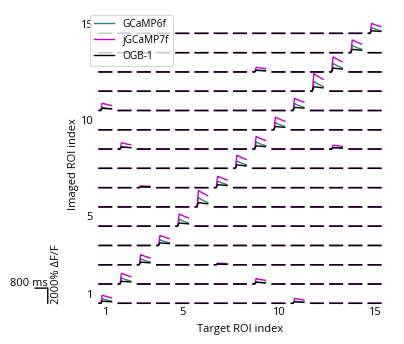

In [11]:
# one axis much faster than a subplot grid
fig, ax = plt.subplots(figsize=(4, 4))
dFFs_per_scope_arr = np.array(dFFs_per_scope)
x_space = t_end_ms * 1.5
x_offsets = np.arange(n_targets) * x_space
y_space = dFFs_per_scope_arr.max() * 1.1
y_offsets = np.arange(n_targets) * y_space

for i_target in range(n_targets):
    for i_img in range(n_targets):
        lines = []
        for scope, dFFs, color in zip(
            scopes, dFFs_per_scope_arr, ["#36827f", "#c500cc", "k"]
        ):
            color = str(color)
            lines.append(
                ax.plot(
                    t_ms + x_offsets[i_target],
                    dFFs[i_target, :, i_img] + y_offsets[i_img],
                    c=color,
                    rasterized=True,
                    lw=1,
                    label=scope.sensor.name,
                )[0]
            )
ax.legend(handles=lines)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set(yticks=[], xticks=[])

#################### scale bars ######################
y_scale = 20
x_scale = t_end_ms
y0 = 0
x0 = -4 * t_end_ms
# y (dF/F) scale bar
ax.annotate(
    "",
    xy=(x0, y0),
    xytext=(x0, y0 + y_scale),
    arrowprops=dict(arrowstyle="-", lw=1, shrinkA=0, shrinkB=0),
    annotation_clip=False,
    xycoords="data",
)
ax.annotate(
    f"{y_scale * 100}% ΔF/F",
    xy=(x0 + 200, y0),
    va="bottom",
    ha="left",
    rotation=90,
    annotation_clip=False,
)
# x (time) scale bar
ax.annotate(
    "",
    xy=(x0, y0 + y_scale),
    xytext=(x0 - x_scale, y0 + y_scale),
    arrowprops=dict(arrowstyle="-", lw=1, shrinkA=0, shrinkB=0),
    annotation_clip=False,
)
ax.annotate(
    f"{x_scale} ms",
    xy=(x0, y0 + y_scale),
    va="bottom",
    ha="right",
    annotation_clip=False,
)

#################### label ROI indices ######################
for i_target in range(n_targets):
    i_lbl = i_target + 1
    if i_lbl == 1 or i_lbl % 5 == 0:
        ax.annotate(
            i_lbl,
            xy=(x_offsets[i_target] + t_end_ms / 2, -4),
            xycoords="data",
            va="top",
            ha="center",
            annotation_clip=False,
        )

for i_img in range(n_targets):
    i_lbl = i_img + 1
    if i_lbl == 1 or i_lbl % 5 == 0:
        ax.annotate(
            i_lbl,
            xy=(-400, y_offsets[i_img] + dFFs_per_scope_arr.max() / 2),
            xycoords="data",
            va="center",
            ha="right",
            annotation_clip=False,
        )

ax.set(xlabel="Target ROI index", ylabel="Imaged ROI index")

fig.savefig(
    "img/fig/all-optical-traces.svg", bbox_inches="tight", dpi=300, transparent=True
)

## Gaussian point spread function

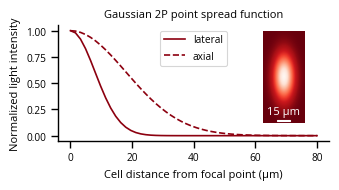

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sigma_r = laser.light_model.sigma_lateral
sigma_z = laser.light_model.sigma_axial


def bivariate_gaussian(r, z):
    p = r**2 / sigma_r**2 + z**2 / sigma_z**2
    return np.exp(-p / 2)


fig, ax = plt.subplots(figsize=(3.5, 1.5))
r = np.linspace(0, 80) * b2.um
pc_axial = np.exp(-(r**2) / (2 * laser.light_model.sigma_axial**2))
pc_lat = np.exp(-(r**2) / (2 * laser.light_model.sigma_lateral**2))
pc_lat = bivariate_gaussian(r, 0 * b2.um)
pc_axial = bivariate_gaussian(0 * b2.um, r)

ax.plot(r / b2.um, pc_lat, label="lateral", c="xkcd:crimson")
ax.plot(r / b2.um, pc_axial, label="axial", linestyle="--", c="xkcd:crimson")
ax.set(
    xlabel="Cell distance from focal point (µm)",
    ylabel="Normalized light intensity",
    title="Gaussian 2P point spread function",
)
# fig.suptitle("Gaussian two-photon point spread function")
ax.legend(loc="upper center")


# Create a grid of x and y values
rlim = (-3 * sigma_r, 3 * sigma_r)
zlim = (-3 * sigma_z, 3 * sigma_z)
x = np.linspace(*rlim, 100)
y = np.linspace(*zlim, 100)
X, Y = np.meshgrid(x, y)

# Evaluate the bivariate Gaussian function on the grid
P = bivariate_gaussian(X, Y)

# Create the inset axis
axins = inset_axes(ax, width="30%", height="80%", loc="upper right")

# Plot the 2D Gaussian function on the inset axis
im = axins.imshow(P, cmap="Reds_r", extent=(*rlim / b2.um, *zlim / b2.um))
scale_um = 15
axins.add_artist(
    AnchoredSizeBar(
        axins.transData,
        scale_um,
        f"{scale_um} µm",
        "lower center",
        frameon=False,
        color="w",
        label_top=True,
        size_vertical=1,
    )
)
axins.set_axis_off()

fig.savefig(
    "img/fig/all-optical-psf.svg", bbox_inches="tight", dpi=300, transparent=True
)

## Environment

In [13]:
!pip freeze

alabaster==0.7.13
anyio==4.1.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.1
astunparse==1.6.3
async-lru==2.0.4
attrs==23.2.0
Babel==2.13.1
beautifulsoup4==4.12.2
bidict==0.22.1
bleach==6.1.0
Brian2==2.5.4
certifi==2023.11.17
cffi==1.16.0
charset-normalizer==3.3.2
-e git+https://github.com/Sensory-Information-Processing-Lab/Cleo.git@4b32fb8df7daf597d6fe8bb40f6f6982347c78fb#egg=cleosim
click==8.1.7
colorama==0.4.6
comm==0.2.0
contourpy==1.2.0
cycler==0.12.1
Cython==3.0.6
debugpy==1.8.0
decorator==5.1.1
defusedxml==0.7.1
docutils==0.20.1
elephant==0.13.0
entrypoints==0.4
execnb==0.1.5
execnet==2.0.2
executing==2.0.1
fastcore==1.5.29
fastjsonschema==2.19.0
fonttools==4.46.0
fqdn==1.5.1
furo==2024.1.29
ghapi==1.0.4
greenlet==3.0.1
idna==3.6
imagesize==1.4.1
importlib-metadata==7.0.0
importlib-resources==6.1.1
iniconfig==2.0.0
ipykernel==6.27.1
ipython==8.18.1
ipython-genutils==0.2.0
ipywidgets==7.8.1
isoduration==20.11.0
jedi==0.19.1
Jinja2==3.1.2
json5==0.